# Movable Emojis

### Logging Utils

In [1]:
import matplotlib.pyplot as plt
import torch
from einops import rearrange
from controllable_nca.utils import load_emoji, rgb

def plot_img(img):
    with torch.no_grad():
        rgb_image = rgb(img, False).squeeze().detach().cpu().numpy()
    rgb_image = rearrange(rgb_image, "c w h -> w h c")
    _ = plt.imshow(rgb_image)
    plt.show()


## Imports

In [2]:
from controllable_nca.experiments.movable_emoji.movable_emoji_dataset import MovableEmojiDataset
from controllable_nca.experiments.movable_emoji.trainer import MovableEmojiNCATrainer
from controllable_nca.nca import ControllableNCA

### Load Dataset

In [3]:
dataset = MovableEmojiDataset()

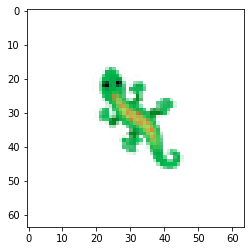

In [4]:
dataset.visualize(32, 32)

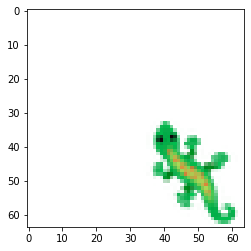

In [5]:
dataset.visualize(48, 48)

In [7]:
NUM_HIDDEN_CHANNELS = 32

nca =  ControllableNCA(num_goals=dataset.num_goals(), target_shape=dataset.target_size(), living_channel_dim=3, num_hidden_channels=NUM_HIDDEN_CHANNELS, cell_fire_rate=1.0)

In [8]:
device = torch.device('cuda')
nca = nca.to(device)
dataset.to(device)

In [10]:
trainer = MovableEmojiNCATrainer(nca, dataset, nca_steps=[48, 64], lr=1e-3, num_damaged=0, damage_radius=3, device=device, pool_size=1024)

Writing to tensorboard_logs/2022-02-18 13:02:51.124102


In [ ]:
# trainer.train(batch_size=24, epochs=100000)

In [11]:
from threading import Event, Thread

import cv2
import numpy as np
import torch
from einops import rearrange
from ipycanvas import Canvas, hold_canvas  # noqa
from ipywidgets import Button, HBox, VBox

from controllable_nca.utils import create_2d_circular_mask, rgb


def to_numpy_rgb(x, use_rgb=False):
    return rearrange(
        np.squeeze(rgb(x, use_rgb).detach().cpu().numpy()), "c x y -> x y c"
    )


class ControllableNCAImageVisualizer:
    def __init__(
        self,
        trainer,
        image_size,
        rgb: bool = False,
        canvas_scale=5,
        damage_radius: int = 5,
    ):
        self.trainer = trainer
        self.current_state = None
        self.current_embedding = None

        self.image_size = image_size
        self.rgb = rgb
        self.canvas_scale = canvas_scale
        self.canvas_size = self.image_size * self.canvas_scale

        self.canvas = Canvas(width=self.canvas_size, height=self.canvas_size)
        self.canvas.on_mouse_down(self.handle_mouse_down)
        self.stopped = Event()

        x = self.trainer.target_dataset.x
        # with torch.no_grad():
        #     self.embeddings = self.trainer.target_dataset.one_hot
        self.current_embedding = self.trainer.nca.encoder(torch.tensor(0, device=self.trainer.device))

        self.device = self.trainer.device
        self.damage_radius = damage_radius
        self.current_state = self.trainer.nca.generate_seed(1).to(self.device)
        
        def button_fn(class_num):
            def start(btn):
                self.current_embedding = self.trainer.nca.encoder(torch.tensor(class_num, device=self.trainer.device))
                if self.stopped.isSet():
                    self.stopped.clear()
                    Thread(target=self.loop).start()

            return start

        button_list = []
        for i in range(5):
            button_list.append(Button(description="{}".format(i)))
            button_list[-1].on_click(button_fn(i))

        self.vbox = VBox(button_list)

        self.stop_btn = Button(description="Stop")

        def stop(btn):
            if not self.stopped.isSet():
                self.stopped.set()

        self.stop_btn.on_click(stop)

    def handle_mouse_down(self, xpos, ypos):
        in_x = int(xpos / self.canvas_scale)
        in_y = int(ypos / self.canvas_scale)

        mask = create_2d_circular_mask(
            self.image_size,
            self.image_size,
            (in_x, in_y),
            radius=self.damage_radius,
        )
        self.current_state[0][:, mask] *= 0.0

    def draw_image(self, rgb):
        with hold_canvas(self.canvas):
            rgb = np.squeeze(rearrange(rgb, "b c w h -> b w h c"))
            self.canvas.clear()  # Clear the old animation step
            self.canvas.put_image_data(
                cv2.resize(
                    rgb * 255.0,
                    (self.canvas_size, self.canvas_size),
                    interpolation=cv2.INTER_NEAREST,
                ),
                0,
                0,
            )

    def loop(self):
        with torch.no_grad():
            self.current_state = self.trainer.nca.generate_seed(1).to(self.device)
            while not self.stopped.wait(0.02):  # the first call is in `interval` secs
                # update_particle_locations()
                self.draw_image(self.trainer.to_rgb(self.current_state))
                self.current_state = self.trainer.nca.grow(
                    self.current_state, 1, self.current_embedding
                )

    def visualize(self):
        Thread(target=self.loop).start()
        display(self.canvas, HBox([self.stop_btn, self.vbox]))  # noqa


In [12]:
nca.load("/home/kokkgoblin/Code/controllable-ncas/examples/newest.pt")

In [13]:
viz = ControllableNCAImageVisualizer(trainer, 64)

In [14]:
viz.visualize()

Canvas(height=320, width=320)